In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score, accuracy_score
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.utils import class_weight

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import pearsonr

In [20]:
data = pd.read_csv('training_data/eurusd_final_dataset.csv')

# I am dropping because I don't want to use these features in the model currently
X = data.drop(['label', 'Date_Time', 'hour', 'dayofweek', 'mins_into_m15', 'frac_into_m15'], axis=1)
y = data['label']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Attempting to create a NN with the whole data set, using changed weights - Failed

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

# Use the integer version of the labels here
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to a dict if needed
class_weights = dict(enumerate(class_weights))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_cat, class_weight=class_weights, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
3837/3837 [==============================] - 18s 4ms/step - loss: 1.3467 - accuracy: 0.5228 - val_loss: 1.1866 - val_accuracy: 0.5386
Epoch 2/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3235 - accuracy: 0.5433 - val_loss: 1.1862 - val_accuracy: 0.5391
Epoch 3/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3177 - accuracy: 0.5461 - val_loss: 1.1504 - val_accuracy: 0.5503
Epoch 4/20
3837/3837 [==============================] - 17s 5ms/step - loss: 1.3141 - accuracy: 0.5454 - val_loss: 1.1737 - val_accuracy: 0.5368
Epoch 5/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3116 - accuracy: 0.5467 - val_loss: 1.1710 - val_accuracy: 0.5512
Epoch 6/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3090 - accuracy: 0.5458 - val_loss: 1.1620 - val_accuracy: 0.5509
Epoch 7/20
3837/3837 [==============================] - 17s 5ms/step - loss: 1.3082 - accuracy: 0.5461 - val_loss: 1.1455 - val_ac

In [ ]:
# Predict
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics
print("Keras Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
#plt.xlabel("Predicted")
#plt.ylabel("True")
#plt.show()

# Per-class Precision/Recall/F1
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
for i in range(5):
    print(f"Class {i} — Precision: {prec[i]:.2f}, Recall: {rec[i]:.2f}, F1: {f1[i]:.2f}")

1066/1066 [==============================] - 3s 3ms/step
Keras Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     16072
           1       0.50      0.40      0.44     12110
           2       0.26      0.33      0.29      3738
           3       0.16      0.31      0.21      1243
           4       0.24      0.28      0.26       941

    accuracy                           0.55     34104
   macro avg       0.38      0.41      0.39     34104
weighted avg       0.57      0.55      0.56     34104

Confusion Matrix:
Class 0 — Precision: 0.75, Recall: 0.75, F1: 0.75
Class 1 — Precision: 0.50, Recall: 0.40, F1: 0.44
Class 2 — Precision: 0.26, Recall: 0.33, F1: 0.29
Class 3 — Precision: 0.16, Recall: 0.31, F1: 0.21
Class 4 — Precision: 0.24, Recall: 0.28, F1: 0.26


In [ ]:
# Simulated trade logic example: TP = +2, SL = -1 per class prediction
profit_rules = {0: 2, 1: -1, 2: 2, 3: -1, 4: 0}

# Assume true class is the correct "direction" — reward if prediction matches
profits = [profit_rules[p] if p == t else -1 for p, t in zip(y_pred, y_test)]
total_profit = sum(profits)

print(f"Simulated Profit: {total_profit}")

#### Attempting to create an NN but with rolling window

In [29]:
# Parameters
window_size = 5000
val_size = 1000
step = 1000
cost_per_trade = 1.5  # in pips

input_features = X_scaled.shape[1]

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Tracking
f1_per_window, acc_per_window, profit_per_window = [], [], []
vol_per_window, trend_15_per_window, vol_1h_per_window = [], [], []
window_indices = []

duration_by_class = {0: [], 1: [], 3: [], 4: []}

# SL/TP search space
tp_values = [10, 20, 30, 40]
sl_values = [8, 10, 12, 14]

class_to_direction = {0: -1, 1: -1, 2: 0, 3: 1, 4: 1}

# Market data
volatility_local = data['vol_local'].values
trend_15m = data['roll_m15_trend'].values
vol_1h = data['roll_h1_vol'].values
close_prices = data['Close'].values
highs_full = data['High'].values
lows_full = data['Low'].values

# Prediction horizon
steps = int(60 / 5)  # 1 hour = 12 candles

# --- Phase 1: Optimize SL/TP per class ---
print("\n--- Optimizing SL/TP per class ---")
sl_tp_map = {}
for cls in [0, 1, 3, 4]:
    best_profit = -np.inf
    best_pair = (12, 20)
    for sl in sl_values:
        for tp in tp_values:
            temp_profit = 0
            count = 0
            for i, start in enumerate(range(0, len(X_scaled) - window_size - val_size - steps, step)):
                val_y = y[start+window_size:start+window_size+val_size]
                val_start = start + window_size
                max_len = min(val_size, len(data) - val_start - steps)

                entry_prices = close_prices[val_start:val_start + max_len]
                future_highs_seq = [highs_full[t:t+steps] for t in range(val_start, val_start + max_len)]
                future_lows_seq = [lows_full[t:t+steps] for t in range(val_start, val_start + max_len)]
                val_preds = val_y[:max_len]  # use true class as simulated prediction

                for pred, entry, highs_seq, lows_seq in zip(val_preds, entry_prices, future_highs_seq, future_lows_seq):
                    if pred != cls:
                        continue
                    direction = class_to_direction[pred]
                    outcome, _ = simulate_trade(entry, highs_seq, lows_seq, direction, sl, tp)
                    if outcome == 'TP':
                        temp_profit += tp
                    elif outcome == 'SL':
                        temp_profit -= sl
                    temp_profit -= cost_per_trade
                    count += 1
            if count > 0 and temp_profit > best_profit:
                best_profit = temp_profit
                best_pair = (sl, tp)
    sl_tp_map[cls] = {'sl': best_pair[0], 'tp': best_pair[1]}
    print(f"Class {cls}: Best SL/TP = {best_pair} with Profit = {best_profit:.2f}")

# Hardcode for class 2 (no trade)
sl_tp_map[2] = {'sl': None, 'tp': None}


--- Optimizing SL/TP per class ---


KeyboardInterrupt: 

In [ ]:
# --- Phase 2: Estimate average SL/TP durations ---
print("\n--- Estimating average SL/TP durations per class ---")
for i, start in enumerate(range(0, len(X_scaled) - window_size - val_size - steps, step)):
    train_y = y[start:start+window_size]
    val_y = y[start+window_size:start+window_size+val_size]

    val_start = start + window_size
    max_len = min(val_size, len(data) - val_start - steps)

    entry_prices = close_prices[val_start:val_start + max_len]
    future_highs_seq = [highs_full[t:t+steps] for t in range(val_start, val_start + max_len)]
    future_lows_seq = [lows_full[t:t+steps] for t in range(val_start, val_start + max_len)]
    val_preds = val_y[:max_len]  # simulated pred = true class to collect durations

    for pred, entry, highs_seq, lows_seq in zip(val_preds, entry_prices, future_highs_seq, future_lows_seq):
        direction = class_to_direction.get(pred, 0)
        if direction == 0:
            continue

        sltp = sl_tp_map.get(pred, {'sl': None, 'tp': None})
        if sltp['sl'] is None or sltp['tp'] is None:
            continue

        result, duration = simulate_trade(entry, highs_seq, lows_seq, direction, sltp['sl'], sltp['tp'])
        if pred in duration_by_class:
            duration_by_class[pred].append(duration)

# Convert to averages
avg_duration_by_class = {k: round(np.mean(v)) if v else steps for k, v in duration_by_class.items()}
print("Average durations (candles):", avg_duration_by_class)


--- Estimating average SL/TP durations per class ---
Average durations (candles): {0: 7, 1: 7, 3: 7, 4: 7}


In [ ]:
# --- Phase 3: Train and evaluate model with optimized SL/TP ---
print("\n--- Training and simulating with optimized SL/TP ---")
for i, start in enumerate(range(0, len(X_scaled) - window_size - val_size - steps, step)):
    train_X = X_scaled[start:start+window_size]
    val_X = X_scaled[start+window_size:start+window_size+val_size]
    train_y = y[start:start+window_size]
    val_y = y[start+window_size:start+window_size+val_size]

    train_y_cat = to_categorical(train_y, num_classes=5)
    val_y_cat = to_categorical(val_y, num_classes=5)

    cw = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced', classes=np.unique(train_y), y=train_y)))

    model = build_model(train_X.shape[1])
    model.fit(train_X, train_y_cat,
              validation_data=(val_X, val_y_cat),
              epochs=30, batch_size=32,
              class_weight=cw,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
              verbose=0)

    preds = np.argmax(model.predict(val_X, verbose=0), axis=1)
    f1 = f1_score(val_y, preds, average='weighted')
    acc = accuracy_score(val_y, preds)

    # Trade simulation
    val_start = start + window_size
    max_len = min(val_size, len(data) - val_start - steps)

    entry_prices = close_prices[val_start:val_start + max_len]
    future_highs_seq = [highs_full[t:t+steps] for t in range(val_start, val_start + max_len)]
    future_lows_seq = [lows_full[t:t+steps] for t in range(val_start, val_start + max_len)]

    profit = 0
    trades = 0

    for pred, entry, highs_seq, lows_seq in zip(preds[:max_len], entry_prices, future_highs_seq, future_lows_seq):
        direction = class_to_direction.get(pred, 0)
        if direction == 0:
            continue

        sltp = sl_tp_map.get(pred, {'sl': None, 'tp': None})
        if sltp['sl'] is None or sltp['tp'] is None:
            continue

        limit = avg_duration_by_class.get(pred, steps)
        highs_limited = highs_seq[:limit]
        lows_limited = lows_seq[:limit]

        outcome, duration = simulate_trade(entry, highs_limited, lows_limited, direction, sltp['sl'], sltp['tp'])

        if outcome == 'TP':
            result = sltp['tp']
        elif outcome == 'SL':
            result = -sltp['sl']
        else:
            result = 0

        result -= cost_per_trade
        profit += result
        trades += 1

    # Log
    profit_per_window.append(profit)
    f1_per_window.append(f1)
    acc_per_window.append(acc)
    vol_per_window.append(np.mean(volatility_local[val_start:val_start + val_size]))
    trend_15_per_window.append(np.mean(trend_15m[val_start:val_start + val_size]))
    vol_1h_per_window.append(np.mean(vol_1h[val_start:val_start + val_size]))
    window_indices.append(i)

    print(f"Window {i}: F1 = {f1:.3f}, Accuracy = {acc:.3f}, Profit = {profit:.2f}, Trades = {trades}")



--- Training and simulating with optimized SL/TP ---
Window 0: F1 = 0.550, Accuracy = 0.482, Profit = -688.00, Trades = 500
Window 1: F1 = 0.566, Accuracy = 0.504, Profit = -465.00, Trades = 510
Window 2: F1 = 0.426, Accuracy = 0.340, Profit = -700.00, Trades = 688
Window 3: F1 = 0.667, Accuracy = 0.629, Profit = -494.00, Trades = 308
Window 4: F1 = 0.554, Accuracy = 0.500, Profit = -562.50, Trades = 483
Window 5: F1 = 0.652, Accuracy = 0.592, Profit = -653.00, Trades = 378
Window 6: F1 = 0.563, Accuracy = 0.551, Profit = -284.00, Trades = 364
Window 7: F1 = 0.543, Accuracy = 0.475, Profit = -510.50, Trades = 503
Window 8: F1 = 0.403, Accuracy = 0.352, Profit = -1645.50, Trades = 649
Window 9: F1 = 0.469, Accuracy = 0.418, Profit = -860.00, Trades = 592
Window 10: F1 = 0.522, Accuracy = 0.433, Profit = -975.00, Trades = 562
Window 11: F1 = 0.485, Accuracy = 0.428, Profit = -978.00, Trades = 540
Window 12: F1 = 0.622, Accuracy = 0.559, Profit = -441.00, Trades = 414
Window 13: F1 = 0.6

KeyboardInterrupt: 

In [ ]:
print("\n📉 Correlation with Accuracy:")
print(f"1H Volatility: {pearsonr(acc_per_window, vol_1h_per_window)[0]:.2f}")
print(f"15m Trend: {pearsonr(acc_per_window, trend_15_per_window)[0]:.2f}")
print(f"Local volatility: {pearsonr(acc_per_window, vol_per_window)[0]:.2f}")


print("\n📈 Correlation with F1 Score:")
print(f"1H Volatility: {pearsonr(f1_per_window, vol_1h_per_window)[0]:.2f}")
print(f"15m Trend:     {pearsonr(f1_per_window, trend_15_per_window)[0]:.2f}")
print(f"Local volatility: {pearsonr(f1_per_window, vol_per_window)[0]:.2f}")


📉 Correlation with Accuracy:
1H Volatility: -0.68
15m Trend: -0.17
Local volatility: -0.68

📈 Correlation with F1 Score:
1H Volatility: -0.80
15m Trend:     -0.20
Local volatility: -0.80


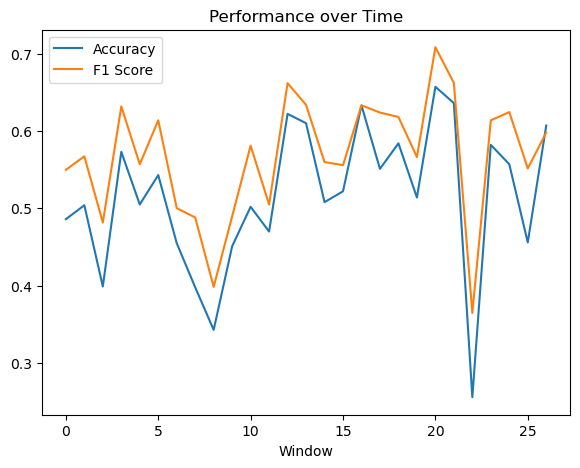

In [ ]:
# Optional: plot drift
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(window_indices, acc_per_window, label="Accuracy")
plt.plot(window_indices, f1_per_window, label="F1 Score")
plt.xlabel("Window")
plt.title("Performance over Time")
plt.legend()

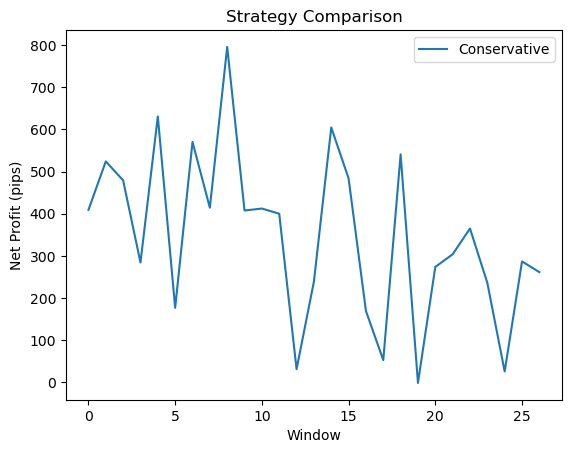

In [ ]:
plt.plot(profit_per_window, label='Conservative')
plt.xlabel('Window')
plt.ylabel('Net Profit (pips)')
plt.legend()
plt.title('Strategy Comparison')
plt.show()

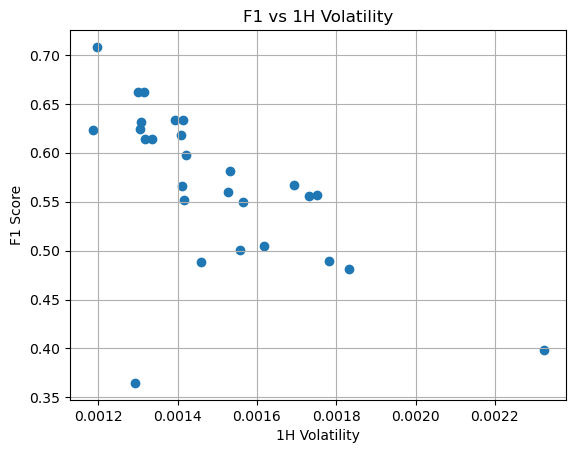

In [ ]:
plt.figure()
plt.scatter(vol_1h_per_window, f1_per_window)
plt.xlabel("1H Volatility")
plt.ylabel("F1 Score")
plt.title("F1 vs 1H Volatility")
plt.grid(True)
plt.show()

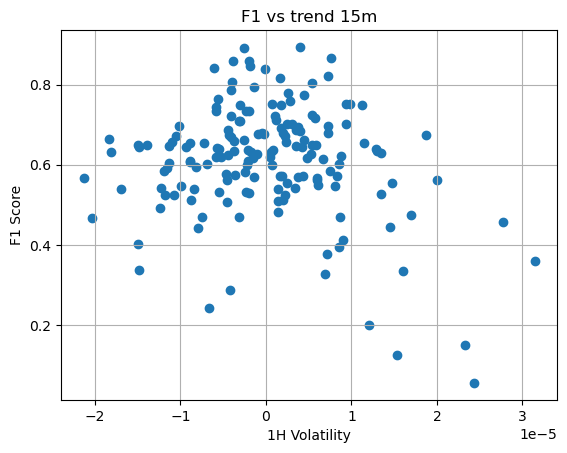

In [ ]:
plt.figure()
plt.scatter(trend_15_per_window, f1_per_window)
plt.xlabel("1H Volatility")
plt.ylabel("F1 Score")
plt.title("F1 vs trend 15m")
plt.grid(True)
plt.show()

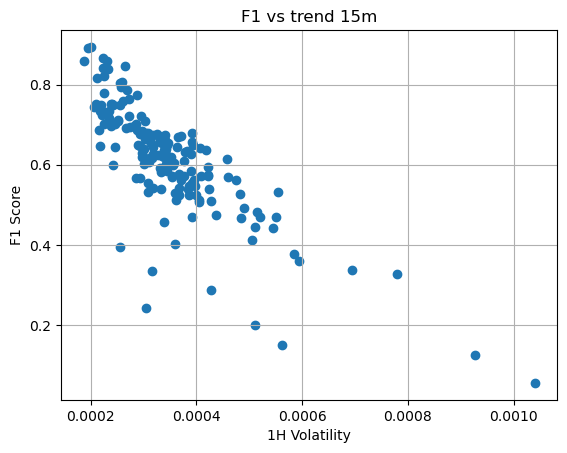

In [ ]:
plt.figure()
plt.scatter(vol_per_window, f1_per_window)
plt.xlabel("1H Volatility")
plt.ylabel("F1 Score")
plt.title("F1 vs trend 15m")
plt.grid(True)
plt.show()

#### Another try

In [33]:
data = pd.read_csv('eurusd_final_dataset.csv')

# I am dropping because I don't want to use these features in the model currently
X = data.drop(['label', 'Date_Time'], axis=1)
y = data['label']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# Parameters
window_size = 5000
val_size = 1000
step = 1000
cost_per_trade = 1.5  # in pips

input_features = X_scaled.shape[1]

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Tracking
f1_per_window, acc_per_window, profit_per_window = [], [], []
vol_per_window, trend_15_per_window, vol_1h_per_window = [], [], []
window_indices = []

duration_by_class = {0: [], 1: [], 3: [], 4: []}

# SL/TP mapping (you can fine-tune these)
sl_tp_map = {0: {'sl': 14, 'tp': 20},
            1: {'sl': 14, 'tp': 10},
            3: {'sl': 14, 'tp': 10},
            4: {'sl': 14, 'tp': 20}}

class_to_direction = {0: -1, 1: -1, 2: 0, 3: 1, 4: 1}

avg_duration_by_class = {0: 7, 1: 7, 3: 7, 4: 7}

# Market data
volatility_local = data['vol_local'].values
trend_15m = data['roll_m15_trend'].values
vol_1h = data['roll_h1_vol'].values
close_prices = data['Close'].values
highs_full = data['High'].values
lows_full = data['Low'].values

# Prediction horizon
steps = int(7)  # 7 candles

# Trade simulation
def simulate_trade(entry_price, highs, lows, direction, sl, tp):
    for i, (high, low) in enumerate(zip(highs, lows)):
        if direction == 1:
            if (high - entry_price) * 10_000 >= tp:
                return tp, i + 1
            elif (entry_price - low) * 10_000 >= sl:
                return -sl, i + 1
        elif direction == -1:
            if (entry_price - low) * 10_000 >= tp:
                return tp, i + 1
            elif (high - entry_price) * 10_000 >= sl:
                return -sl, i + 1
    final_price = highs[-1] if direction == 1 else lows[-1]
    result = (final_price - entry_price) * 10_000 * direction
    return result, len(highs)

for i, start in enumerate(range(0, len(X_scaled) - window_size - val_size - steps, step)):
    train_X = X_scaled[start:start+window_size]
    val_X = X_scaled[start+window_size:start+window_size+val_size]
    train_y = y[start:start+window_size]
    val_y = y[start+window_size:start+window_size+val_size]

    train_y_cat = to_categorical(train_y, num_classes=5)
    val_y_cat = to_categorical(val_y, num_classes=5)

    cw = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced', classes=np.unique(train_y), y=train_y)))

    model = build_model(train_X.shape[1])
    model.fit(train_X, train_y_cat,
              validation_data=(val_X, val_y_cat),
              epochs=30, batch_size=32,
              class_weight=cw,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
              verbose=0)

    preds = np.argmax(model.predict(val_X, verbose=0), axis=1)
    f1 = f1_score(val_y, preds, average='weighted')
    acc = accuracy_score(val_y, preds)

    # Trade simulation
    val_start = start + window_size
    max_len = min(val_size, len(data) - val_start - steps)

    entry_prices = close_prices[val_start:val_start + max_len]
    future_highs_seq = [highs_full[t:t+steps] for t in range(val_start, val_start + max_len)]
    future_lows_seq = [lows_full[t:t+steps] for t in range(val_start, val_start + max_len)]

    profit = 0
    trades = 0

    for pred, entry, highs_seq, lows_seq in zip(preds[:max_len], entry_prices, future_highs_seq, future_lows_seq):
        direction = class_to_direction.get(pred, 0)
        if direction == 0:
            continue

        sltp = sl_tp_map.get(pred, {'sl': None, 'tp': None})
        if sltp['sl'] is None or sltp['tp'] is None:
            continue

        # Dynamic candle limit per class (if we have past durations)
        limit = avg_duration_by_class.get(pred, steps)
        highs_limited = highs_seq[:limit]
        lows_limited = lows_seq[:limit]

        result, duration = simulate_trade(entry, highs_limited, lows_limited, direction, sltp['sl'], sltp['tp'])
        result -= cost_per_trade
        profit += result
        trades += 1
        if pred in duration_by_class:
            duration_by_class[pred].append(duration)

    # Log
    profit_per_window.append(profit)
    f1_per_window.append(f1)
    acc_per_window.append(acc)
    vol_per_window.append(np.mean(volatility_local[val_start:val_start + val_size]))
    trend_15_per_window.append(np.mean(trend_15m[val_start:val_start + val_size]))
    vol_1h_per_window.append(np.mean(vol_1h[val_start:val_start + val_size]))
    window_indices.append(i)

    print(f"Window {i}: F1 = {f1:.3f}, Accuracy = {acc:.3f}, Profit = {profit:.2f}, Trades = {trades}")

# Final average duration report
print("\n📊 Average SL/TP Duration per Class (candles):")
for cls, durations in duration_by_class.items():
    avg_dur = np.mean(durations) if durations else steps
    print(f"Class {cls}: {avg_dur:.1f} candles")

Window 0: F1 = 0.546, Accuracy = 0.542, Profit = 81.20, Trades = 402
Window 1: F1 = 0.603, Accuracy = 0.611, Profit = 242.40, Trades = 348
Window 2: F1 = 0.507, Accuracy = 0.485, Profit = -233.40, Trades = 471
Window 3: F1 = 0.668, Accuracy = 0.634, Profit = 170.10, Trades = 357


KeyboardInterrupt: 